# Conditional probability for overshoot
Based on brightness temperature & ice above cold point

--> How low do you have to go in brightness temperature before <X% of samples have ice above the cold point?



# TODO: what's with the time issue?
Where dar_rel_dict times =/= tb times

# TODO: to investigate it in WPC, try at different levels... does it level off below 500m? or are probabilities never above ~50% above the ocld poitn?

...copy the code from the old version on github...

Too tired to do this now... need dinner...

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar


In [2]:
season = "JJA"
file_path = "/work/bb1153/b380887/big_obs_climo/"


In [3]:
if season == "DJF":
    region_list = ["AMZ", "ECP", "IOS", "SPC"]
    year_list = [2007, 2008, 2009, 2010]

elif season == "JJA":
    region_list = ["AFR", "ECP", "WPC", "IOE"]
    year_list = [2007, 2008, 2009, 2010] 
    
years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)


2007-2010


## Get the data
Brightness temp & cold point temp at all points in space/time; IWC at 500 m above cold point; time-mean cold points for each region

In [6]:
%%time

dar_dict = {}
tb_dict = {}
cpT_dict = {}
cpT_avg_dict = {}
offset_dict = {}

for region in region_list:
    dar_list = [[]]*len(year_list)
    tb_list = [[]]*len(year_list)
    cpT_list = [[]]*len(year_list)
    
    if "SPC" in region_list:
        dar_1_list = [[]]*len(year_list)
        dar_2_list = [[]]*len(year_list)

    for i, year in enumerate(year_list):
        if region == "SPC":
            iwc500_1 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}1.nc".format(s=season, y=year, r=region))["iwc_a500"]
            iwc500_2 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}2.nc".format(s=season, y=year, r=region))["iwc_a500"] 
            
            temp_1 = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}1.nc".format(s=season, y=year, r=region))["t"]
            temp_2 = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}2.nc".format(s=season, y=year, r=region))["t"]
            cpT_inds_1 = temp_1.chunk("auto").argmin(dim="level").compute()
            cpT_inds_2 = temp_2.chunk("auto").argmin(dim="level").compute()
            cpT_1 = temp_1.isel(level=cpT_inds_1).sel(time=iwc500_1.time, latitude=iwc500_1.lat, longitude=iwc500_1.lon, method="nearest")
            cpT_2 = temp_2.isel(level=cpT_inds_2).sel(time=iwc500_2.time, latitude=iwc500_2.lat, longitude=iwc500_2.lon, method="nearest")
        
            tb_1 = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}1.nc4".format(s=season, y=year, r=region))
            tb_2 = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}2.nc4".format(s=season, y=year, r=region))
        
            tb_dar_1 = tb_1["Tb"].sel(time=iwc500_1.time, lat=iwc500_1.lat, lon=iwc500_1.lon, method="nearest")
            tb_dar_2 = tb_2["Tb"].sel(time=iwc500_2.time, lat=iwc500_2.lat, lon=iwc500_2.lon, method="nearest")

            dar_list[i] = xr.concat([iwc500_1, iwc500_2], dim="time")
            dar_1_list[i] = iwc500_1
            dar_2_list[i] = iwc500_2
            tb_list[i] = xr.concat([tb_dar_1, tb_dar_2], dim="time")
            cpT_list[i] = xr.concat([cpT_1, cpT_2], dim="time")

        else:
            iwc500 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["iwc_a500"]
            temp = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}.nc".format(s=season, r=region, y=year))["t"]
            cpT_inds = temp.chunk("auto").argmin(dim="level").compute()
            cpT = temp.isel(level=cpT_inds).sel(time=iwc500.time, latitude=iwc500.lat, longitude=iwc500.lon, method="nearest")
            tb = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}.nc4".format(s=season, y=year, r=region))
            cpT_list[i] = cpT
            tb_list[i] = tb["Tb"].sel(time=iwc500.time, lat=iwc500.lat, lon=iwc500.lon, method="nearest")
            dar_list[i] = iwc500
        
        print(year, "done")
            
    # combine IWC data arrays over time
    dar_dict[region] = xr.concat(dar_list, dim="time")

    # get time-mean cold point from Tb threshold for overshoot
    if region == "SPC":
        iwc_all_1 = xr.concat(dar_1_list, dim="time")
        iwc_all_2 = xr.concat(dar_2_list, dim="time")
        thresh_025 = xr.open_dataset(file_path + "Tb_os_thresholds/ERA5_0.25deg_cp_thresh_{s}{y}_{r}.nc".format(r=region, y=years_str, s=season))
        cpT_avg_1 = thresh_025["cpT"].sel(longitude=slice(None, 180)).sel(latitude=iwc_all_1.lat, longitude=iwc_all_1.lon, method="nearest")
        cpT_avg_2 = thresh_025["cpT"].sel(longitude=slice(-180, None)).sel(latitude=iwc_all_2.lat, longitude=iwc_all_2.lon, method="nearest")
        cpT_avg = xr.concat([cpT_avg_1, cpT_avg_2], dim="time")
    else:
        thresh_025 = xr.open_dataset(file_path + "Tb_os_thresholds/ERA5_0.25deg_cp_thresh_{s}{y}_{r}.nc".format(r=region, y=years_str, s=season))
        cpT_avg = thresh_025["cpT"].sel(latitude=dar_dict[region].lat, longitude=dar_dict[region].lon, method="nearest")
    
    # combine the other data arrays over time
    cpT_dict[region] = xr.concat(cpT_list, dim="time")
    tb_dict[region] = xr.concat(tb_list, dim="time")
    cpT_avg_dict[region] = cpT_avg
    offset_dict[region] = thresh_025.temp_offset

    print("...{r} done\n".format(r=region))



2007 done
2008 done
2009 done
2010 done
...AFR done

2007 done
2008 done
2009 done
2010 done
...ECP done

2007 done
2008 done
2009 done
2010 done
...WPC done

2007 done
2008 done
2009 done
2010 done
...IOE done

CPU times: user 2min 7s, sys: 1min 59s, total: 4min 7s
Wall time: 12min 27s


In [19]:
tb_dict["WPC"]

<xarray.DataArray 'Tb' (time: 2111339)>
array([293., 293., 293., ..., 293., 293., 293.], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 2007-06-01T02:00:00 ... 2010-08-31T16...
    lon           (time) float64 179.1 179.1 179.1 179.1 ... 141.3 141.3 141.3
    lat           (time) float64 0.01819 0.01819 0.01819 ... 0.01819 0.01819
    height_a1000  (time) float32 1.71e+04 1.71e+04 ... 1.74e+04 1.74e+04
    longitude     (time) float32 179.0 179.0 179.0 179.0 ... 141.2 141.2 141.2
    latitude      (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    level         (time) int64 62 62 62 62 62 62 62 62 ... 61 61 61 61 61 61 61
    height_a500   (time) float32 1.656e+04 1.656e+04 ... 1.686e+04 1.686e+04
    height_cp     (time) float32 1.608e+04 1.608e+04 ... 1.638e+04 1.638e+04
    height_b500   (time) float32 1.56e+04 1.56e+04 ... 1.59e+04 1.59e+04
    height_b1000  (time) float32 1.506e+04 1.506e+04 ... 1.536e+04 1.536e+04
Attributes:
    standard_name:  brightness_temperature
    units:          K
    origname:       Tb
    fullnamepath:   /Tb

### Scatterplot of temp diff vs. amount of ice at 500m
Just to check it out

#### Differences from AVERAGE (varies only in space)

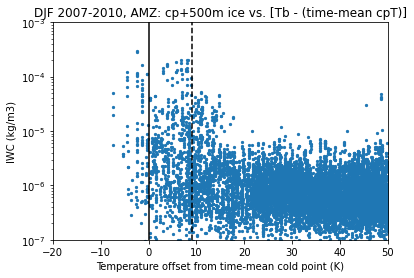

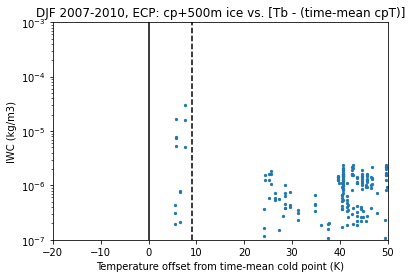

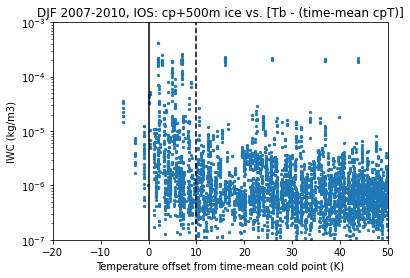

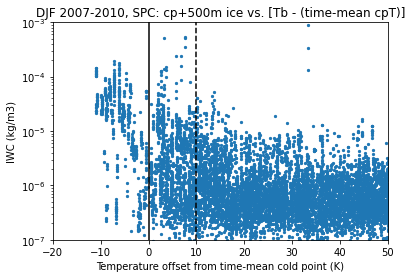

In [10]:
# DJF
xlim = (-20, 50)
ylim = (1e-7, 1e-3)

for region in region_list:
    diff_from_avg = tb_dict[region] - cpT_avg_dict[region].values
    ice500 = dar_dict[region]
    offset = offset_dict[region]

    fig, ax = plt.subplots()
    ax.scatter(diff_from_avg, ice500, s=5)
    ax.set_yscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("{s} {y}, {r}: cp+500m ice vs. [Tb - (time-mean cpT)]".format(s=season, y=years_str, r=region))
    ax.set_ylabel("IWC (kg/m3)")
    ax.set_xlabel("Temperature offset from time-mean cold point (K)")
    ax.axvline(0, color="k")
    ax.axvline(offset, color="k", linestyle="--")
    ax.axhline(0, color="k")
    plt.show()


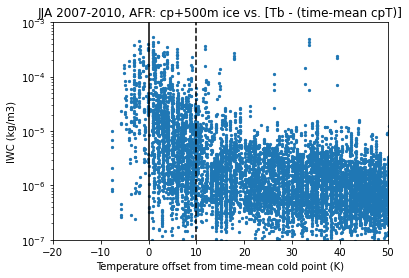

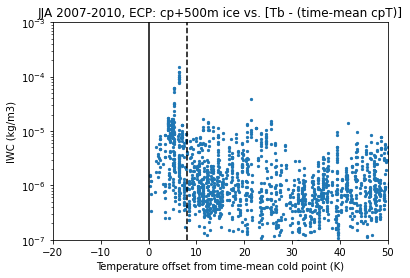

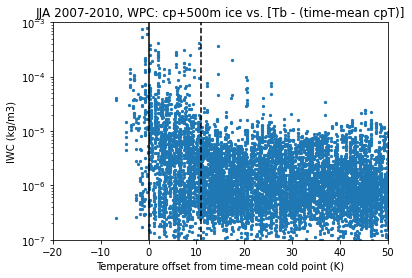

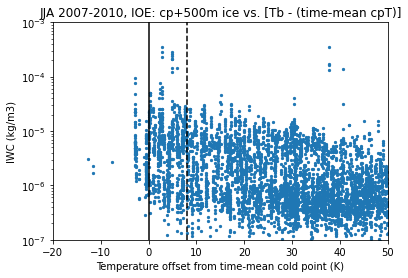

In [7]:
# JJA
xlim = (-20, 50)
ylim = (1e-7, 1e-3)

for region in region_list:
    diff_from_avg = tb_dict[region] - cpT_avg_dict[region].values
    ice500 = dar_dict[region]
    offset = offset_dict[region]

    fig, ax = plt.subplots()
    ax.scatter(diff_from_avg, ice500, s=5)
    ax.set_yscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("{s} {y}, {r}: cp+500m ice vs. [Tb - (time-mean cpT)]".format(s=season, y=years_str, r=region))
    ax.set_ylabel("IWC (kg/m3)")
    ax.set_xlabel("Temperature offset from time-mean cold point (K)")
    ax.axvline(0, color="k")
    ax.axvline(offset, color="k", linestyle="--")
    ax.axhline(0, color="k")
    plt.show()


#### Differences from LOCAL cold point (also varies in time)

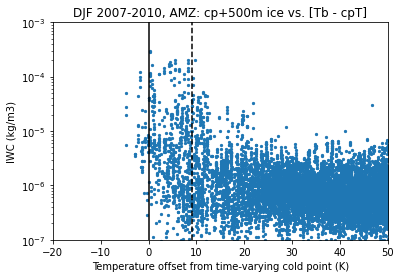

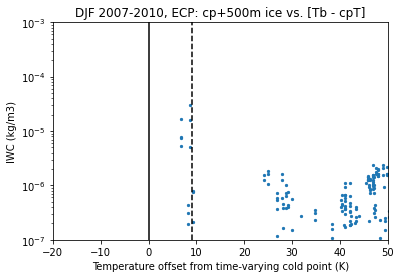

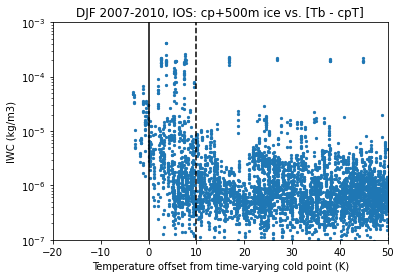

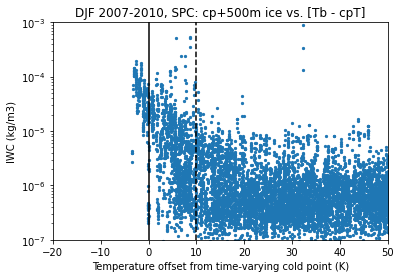

In [11]:
# DJF
xlim = (-20, 50)
ylim = (1e-7, 1e-3)

for region in region_list:
    diff_from_avg = tb_dict[region] - cpT_dict[region].values
    ice500 = dar_dict[region]
    offset = offset_dict[region]

    fig, ax = plt.subplots()
    ax.scatter(diff_from_avg, ice500, s=5)
    ax.set_yscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("{s} {y}, {r}: cp+500m ice vs. [Tb - cpT]".format(s=season, y=years_str, r=region))
    ax.set_ylabel("IWC (kg/m3)")
    ax.set_xlabel("Temperature offset from time-varying cold point (K)")
    ax.axvline(0, color="k")
    ax.axvline(offset, color="k", linestyle="--")
    ax.axhline(0, color="k")
    plt.show()


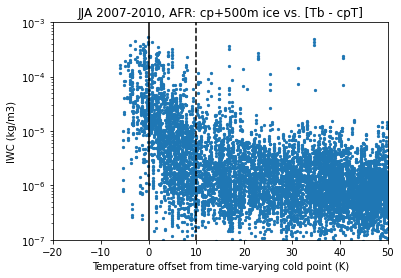

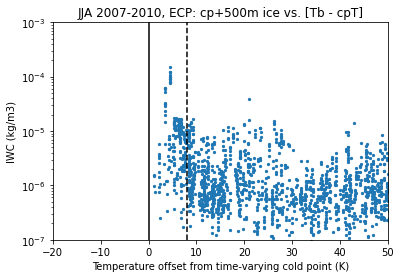

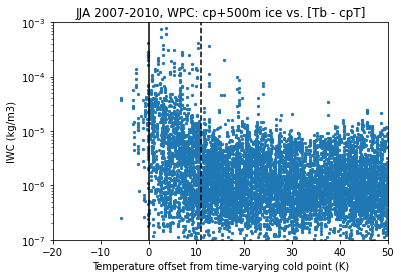

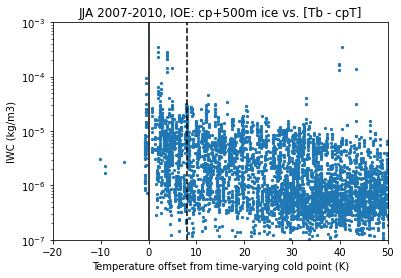

In [8]:
# JJA
xlim = (-20, 50)
ylim = (1e-7, 1e-3)

for region in region_list:
    diff_from_avg = tb_dict[region] - cpT_dict[region].values
    ice500 = dar_dict[region]
    offset = offset_dict[region]

    fig, ax = plt.subplots()
    ax.scatter(diff_from_avg, ice500, s=5)
    ax.set_yscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("{s} {y}, {r}: cp+500m ice vs. [Tb - cpT]".format(s=season, y=years_str, r=region))
    ax.set_ylabel("IWC (kg/m3)")
    ax.set_xlabel("Temperature offset from time-varying cold point (K)")
    ax.axvline(0, color="k")
    ax.axvline(offset, color="k", linestyle="--")
    ax.axhline(0, color="k")
    plt.show()


## Plots!

Note: changing 1e-7 to 0 actually makes little difference, but use it anyway



In [9]:
diff_bins = np.arange(-20, 51, 2)
plot_line = False
min_iwc = 1e-7
save = True
save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/os_cond_probability/"


#### Differences from AVERAGE (varies only in space)

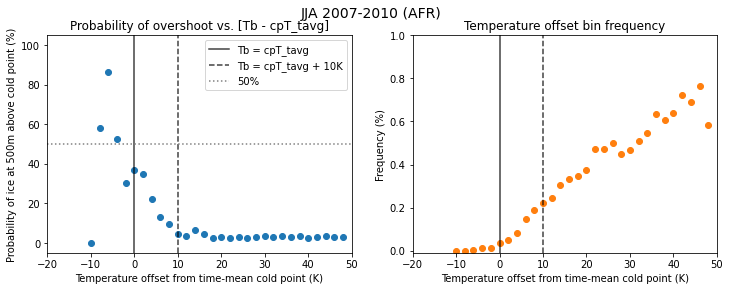

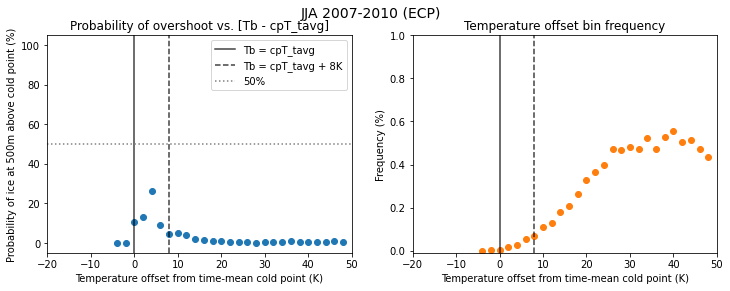

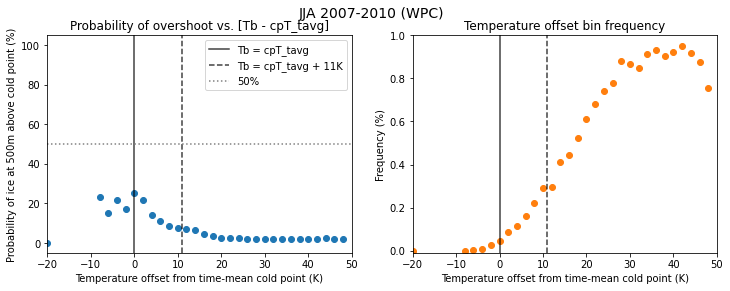

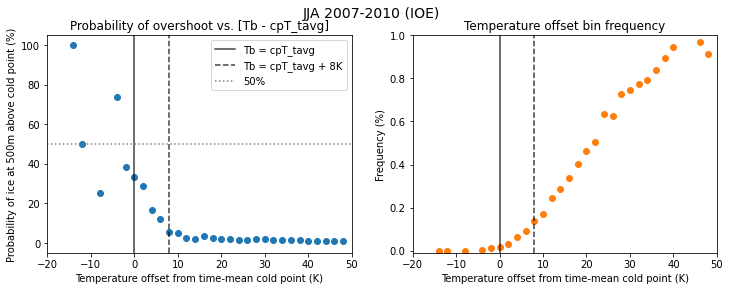

In [10]:
for region in region_list:
    tb = tb_dict[region]
    ice500 = dar_dict[region]
    offset = offset_dict[region]

    # bin the differences 
    diffs = tb_dict[region] - cpT_avg_dict[region].values
    diffs_binned = diffs.groupby_bins(diffs, bins=diff_bins)
    diff_counts = diffs_binned.count()

    # bin ice > min by the tb difference bins
    ice500_nz = ice500.where(ice500 > min_iwc)
    ice500_nz_binned = ice500_nz.assign_coords(time=diffs.time).groupby_bins(diffs, bins=diff_bins)
    ice_nz_counts = ice500_nz_binned.count()

    # plot the fraction
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.axvline(0, color="k", alpha=0.75, label="Tb = cpT_tavg")
    ax1.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax1.axhline(50, color="gray", linestyle=":", label="50%")
    ax1.scatter(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    if plot_line:
        ax1.plot(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    ax1.set_ylim((-5, 105))
    ax1.set_xlim((diff_bins[0], diff_bins[-1]))
    ax1.legend(loc="upper right")
    ax1.set_title("Probability of overshoot vs. [Tb - cpT_tavg]")
    ax1.set_ylabel("Probability of ice at 500m above cold point (%)")
    ax1.set_xlabel("Temperature offset from time-mean cold point (K)")
    
    ax2.set_title("Temperature offset bin frequency")
    ax2.axvline(0, color="k", alpha=0.75, label="Tb = cpT")
    ax2.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax2.scatter(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    if plot_line:
        ax2.plot(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    ax2.set_ylabel("Frequency (%)")
    ax2.set_xlabel("Temperature offset from time-mean cold point (K)")
    ax2.set_xlim((diff_bins[0], diff_bins[-1]))
    ax2.set_ylim((-0.01, 1))

    plt.suptitle("{s} {y} ({r})".format(s=season, y=years_str, r=region), fontsize=14)
    
    if save:
        if plot_line:
            extr = "_with_line"
        else:
            extr = ""
        plt.savefig(save_dir + "conditional_prob_overshoot_from_avg_cpT_{s}{y}_{r}{e}.png".format(s=season, y=years_str, r=region, e=extr),
                    dpi=300, bbox_inches="tight")
    
    plt.show()


#### Differences from LOCAL cold point (also varies in time)

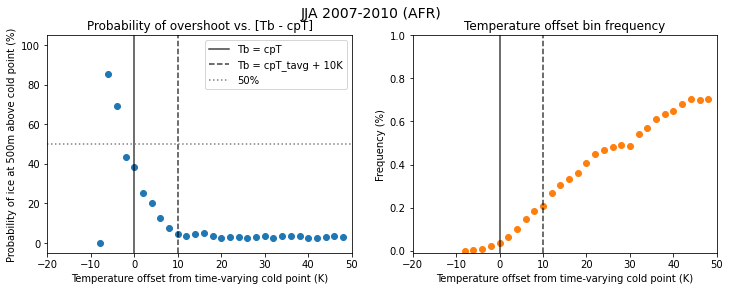

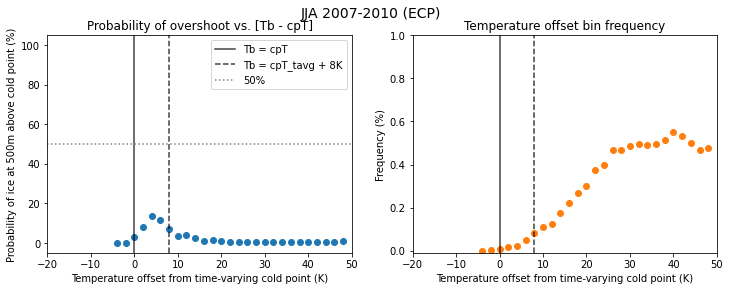

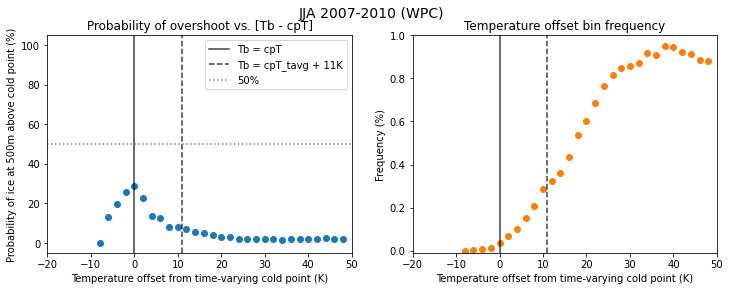

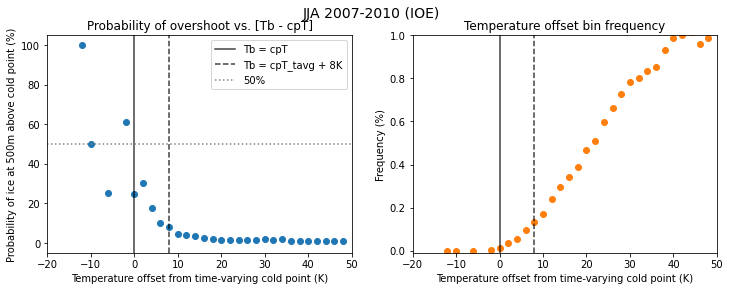

In [11]:
for region in region_list:
    tb = tb_dict[region]
    ice500 = dar_dict[region]
    offset = offset_dict[region]

    # bin the differences 
    diffs = tb_dict[region] - cpT_dict[region].values
    diffs_binned = diffs.groupby_bins(diffs, bins=diff_bins)
    diff_counts = diffs_binned.count()

    # bin ice > min by the tb difference bins
    ice500_nz = ice500.where(ice500 > min_iwc)
    ice500_nz_binned = ice500_nz.assign_coords(time=diffs.time).groupby_bins(diffs, bins=diff_bins)
    ice_nz_counts = ice500_nz_binned.count()

    # plot the fraction
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.axvline(0, color="k", alpha=0.75, label="Tb = cpT")
    ax1.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax1.axhline(50, color="gray", linestyle=":", label="50%")
    ax1.scatter(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    if plot_line:
        ax1.plot(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    ax1.set_ylim((-5, 105))
    ax1.set_xlim((diff_bins[0], diff_bins[-1]))
    ax1.legend(loc="upper right")
    ax1.set_title("Probability of overshoot vs. [Tb - cpT]")
    ax1.set_ylabel("Probability of ice at 500m above cold point (%)")
    ax1.set_xlabel("Temperature offset from time-varying cold point (K)")
    
    ax2.set_title("Temperature offset bin frequency")
    ax2.axvline(0, color="k", alpha=0.75, label="Tb = cpT")
    ax2.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax2.scatter(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    if plot_line:
        ax2.plot(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    ax2.set_ylabel("Frequency (%)")
    ax2.set_xlabel("Temperature offset from time-varying cold point (K)")
    ax2.set_xlim((diff_bins[0], diff_bins[-1]))
    ax2.set_ylim((-0.01, 1))

    plt.suptitle("{s} {y} ({r})".format(s=season, y=years_str, r=region), fontsize=14)
    
    if save:
        if plot_line:
            extr = "_with_line"
        else:
            extr = ""
        plt.savefig(save_dir + "conditional_prob_overshoot_from_local_cpT_{s}{y}_{r}{e}.png".format(s=season, y=years_str, r=region, e=extr),
                    dpi=300, bbox_inches="tight")
    
    plt.show()


## Just WPC
Investigate it at different heights...

In [23]:
%%time

dar_dict = {}
dar_rel_dict = {}
tb_dict = {}
cpz_dict = {}
cpT_dict = {}
cpT_avg_dict = {}
offset_dict = {}

region = "WPC"

dar_rel_year_list = [[]]*len(year_list)
dar_list = [[]]*len(year_list)
tb_list = [[]]*len(year_list)
cpT_list = [[]]*len(year_list)
cpz_list = [[]]*len(year_list)

for i, year in enumerate(year_list):
    dar = xr.open_dataset(file_path + "{s}/DARDAR-v3_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["iwc"]
    cpz = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["height_cp"]
    
    # get (cp - 240 m) to (cp + 940 m) heights
    cpz_range = [
             *[cpz - (60*j) for j in [4, 3, 2, 1]],
             *[cpz + (60*j) for j in range(16)]
    ]
    dar_rel_list_dz = [
        *[0 - (60*j) for j in [4, 3, 2, 1]],
        *[0 + (60*j) for j in range(16)]
    ]
    dar_rel_list = [[]]*len(cpz_range)
    for k, heights in enumerate(cpz_range):
        dar_rel_list[k] = dar.sel(height=heights, method="nearest")
        
    # stack by height; need to explicitly assign the same time to each or it raises an error
    dar_rel_da = xr.concat(
        [dar.assign_coords(time=dar_rel_list[0].time) for dar in dar_rel_list],
        dim="cpz_offset"
    ).assign_coords(cpz_offset=dar_rel_list_dz)

    iwc500 = xr.open_dataset(file_path + "{s}/DARDAR_cp_relative_iwc_{s}{y}_{r}.nc".format(s=season, y=year, r=region))["iwc_a500"]
    temp = xr.open_dataset(file_path + "{s}/ERA5_T_0.25deg_ml_12-20km_{s}{y}_{r}.nc".format(s=season, r=region, y=year))["t"]
    cpT_inds = temp.chunk("auto").argmin(dim="level").compute()
    cpT = temp.isel(level=cpT_inds).sel(time=iwc500.time, latitude=iwc500.lat, longitude=iwc500.lon, method="nearest")
    tb = xr.open_dataset(file_path + "{s}/MERGIR_Tb_4km_{s}{y}_{r}.nc4".format(s=season, y=year, r=region))
    
    cpT_list[i] = cpT
    cpz_list[i] = cpz
    tb_list[i] = tb["Tb"].sel(time=iwc500.time, lat=iwc500.lat, lon=iwc500.lon, method="nearest")
    dar_list[i] = iwc500
    dar_rel_year_list[i] = dar_rel_da
    print(year, "done")

# combine IWC data arrays over time
dar_dict[region] = xr.concat(dar_list, dim="time")
dar_rel_dict[region] = xr.concat(dar_rel_year_list, dim="time")

# get time-mean cold point from Tb threshold for overshoot
thresh_025 = xr.open_dataset(file_path + "Tb_os_thresholds/ERA5_0.25deg_cp_thresh_{s}{y}_{r}.nc".format(r=region, y=years_str, s=season))
cpT_avg = thresh_025["cpT"].sel(latitude=dar_dict[region].lat, longitude=dar_dict[region].lon, method="nearest")

# combine the other data arrays over time
cpT_dict[region] = xr.concat(cpT_list, dim="time")
tb_dict[region] = xr.concat(tb_list, dim="time")
cpT_avg_dict[region] = cpT_avg
offset_dict[region] = thresh_025.temp_offset


2007 done
2008 done
2009 done
2010 done
CPU times: user 2min 1s, sys: 7min 32s, total: 9min 33s
Wall time: 9min


### Scatterplots at each height

In [30]:
dz_plot_list = np.arange(-60, 500, 60)
region = "WPC"

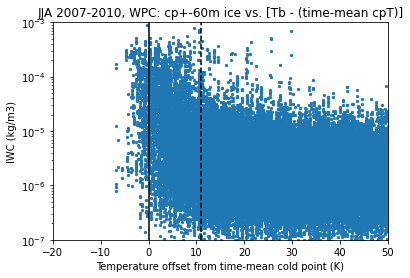

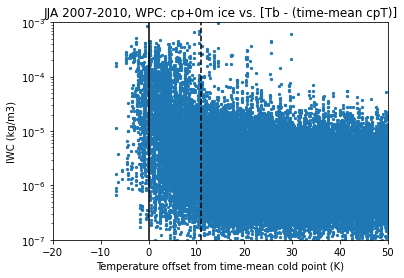

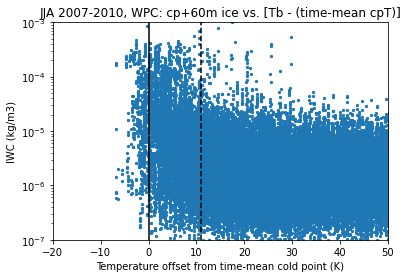

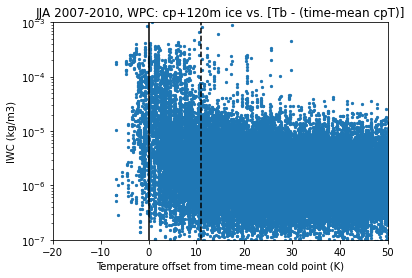

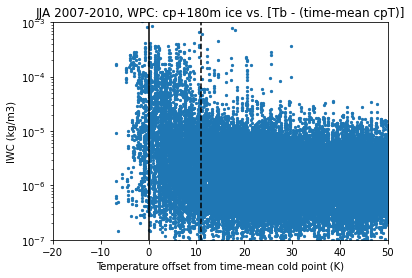

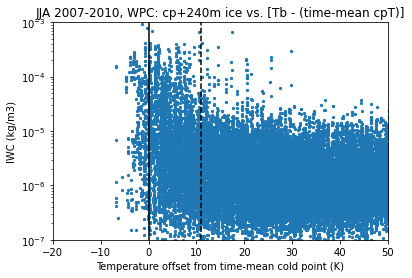

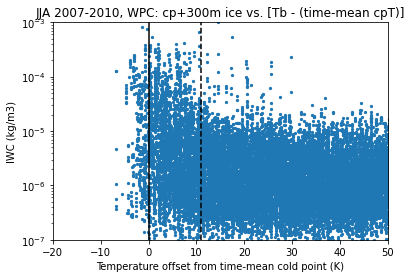

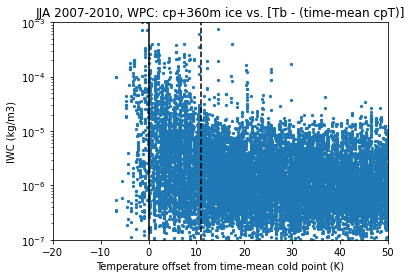

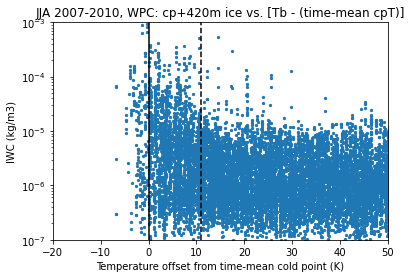

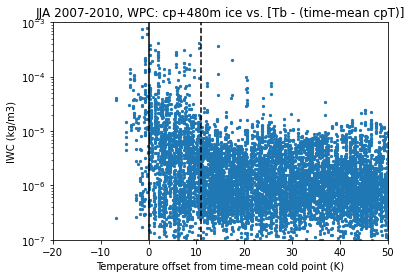

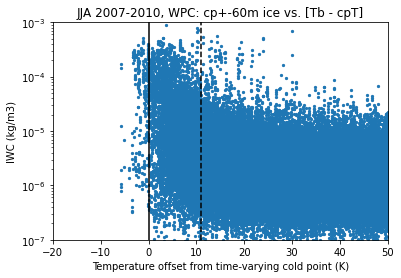

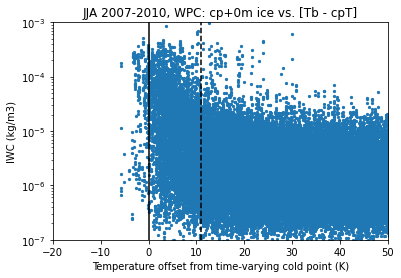

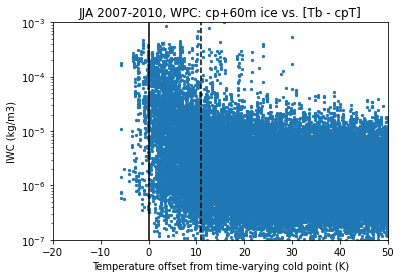

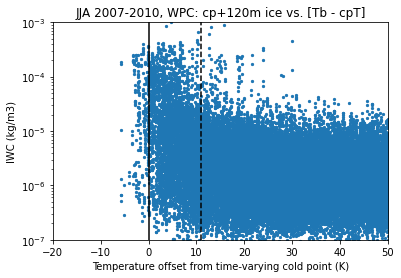

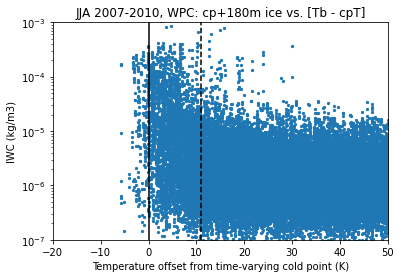

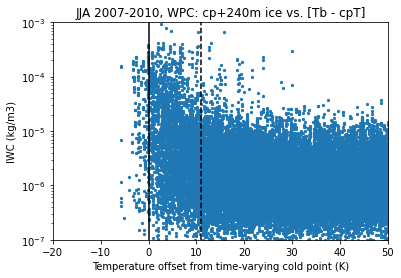

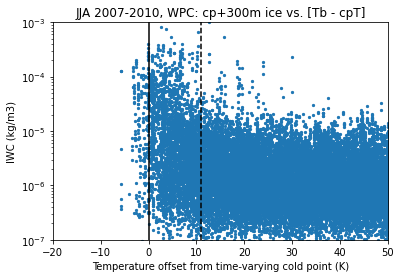

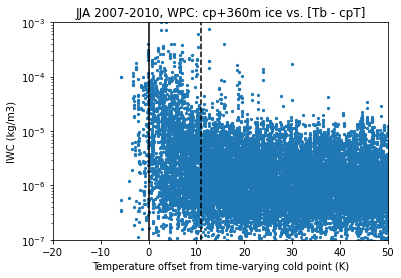

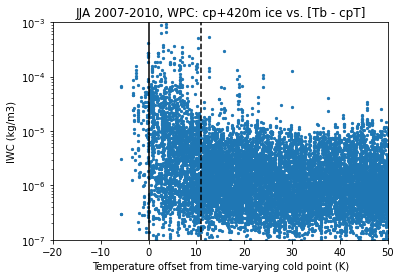

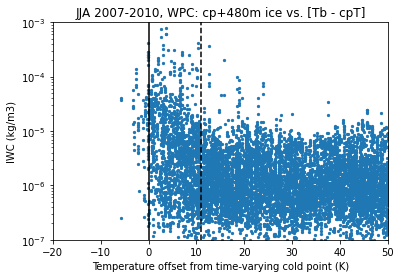

In [31]:
# diffs from AVERAGE cold point
xlim = (-20, 50)
ylim = (1e-7, 1e-3)

for dz in dz_plot_list:
    diff_from_avg = tb_dict[region] - cpT_avg_dict[region].values
    ice = dar_rel_dict[region].sel(cpz_offset=dz)
    offset = offset_dict[region]

    fig, ax = plt.subplots()
    ax.scatter(diff_from_avg, ice, s=5)
    ax.set_yscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("{s} {y}, {r}: cp+{z}m ice vs. [Tb - (time-mean cpT)]".format(z=dz, s=season, y=years_str, r=region))
    ax.set_ylabel("IWC (kg/m3)")
    ax.set_xlabel("Temperature offset from time-mean cold point (K)")
    ax.axvline(0, color="k")
    ax.axvline(offset, color="k", linestyle="--")
    ax.axhline(0, color="k")
    plt.show()
    
# diffs from LOCAL cold point
xlim = (-20, 50)
ylim = (1e-7, 1e-3)

for dz in dz_plot_list:
    diff_from_avg = tb_dict[region] - cpT_dict[region].values
    ice = dar_rel_dict[region].sel(cpz_offset=dz)
    offset = offset_dict[region]

    fig, ax = plt.subplots()
    ax.scatter(diff_from_avg, ice, s=5)
    ax.set_yscale("log")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("{s} {y}, {r}: cp+{z}m ice vs. [Tb - cpT]".format(z=dz, s=season, y=years_str, r=region))
    ax.set_ylabel("IWC (kg/m3)")
    ax.set_xlabel("Temperature offset from time-varying cold point (K)")
    ax.axvline(0, color="k")
    ax.axvline(offset, color="k", linestyle="--")
    ax.axhline(0, color="k")
    plt.show()


In [37]:
diff_bins = np.arange(-20, 51, 2)
plot_line = False
min_iwc = 1e-7
save = True
save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/os_cond_probability/"


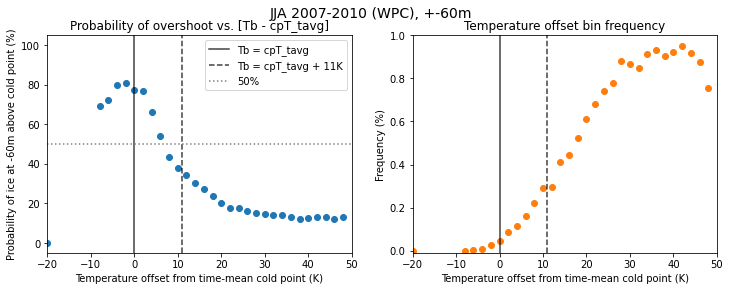

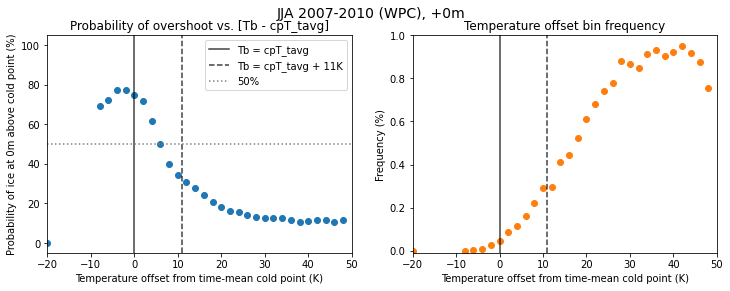

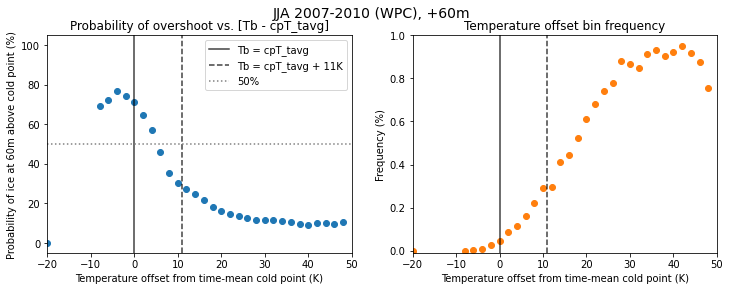

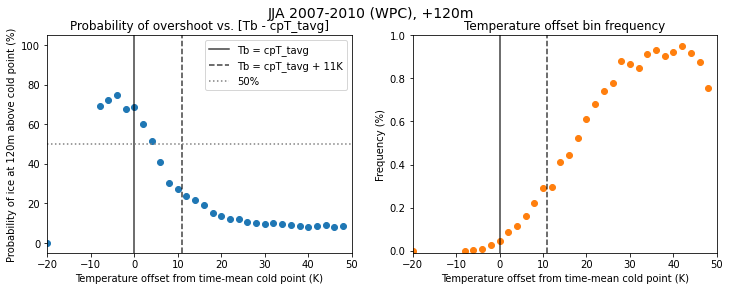

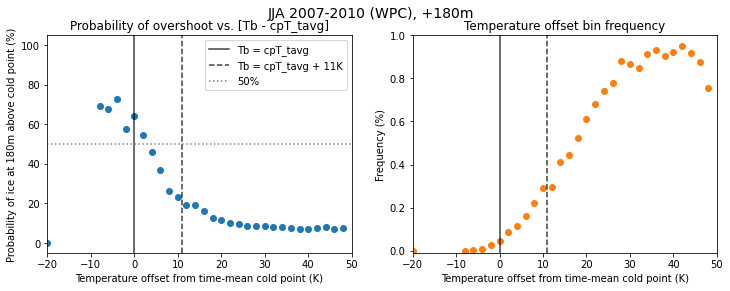

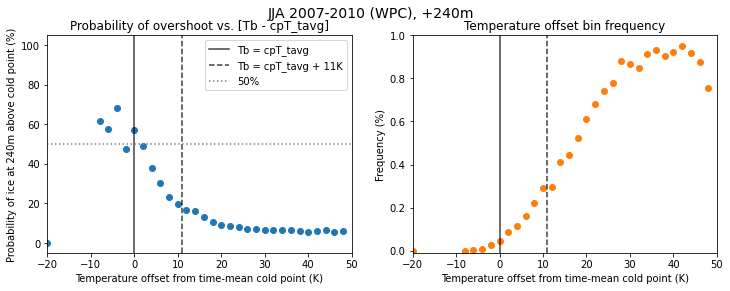

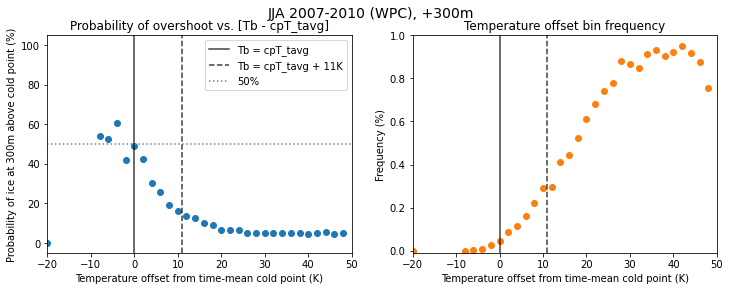

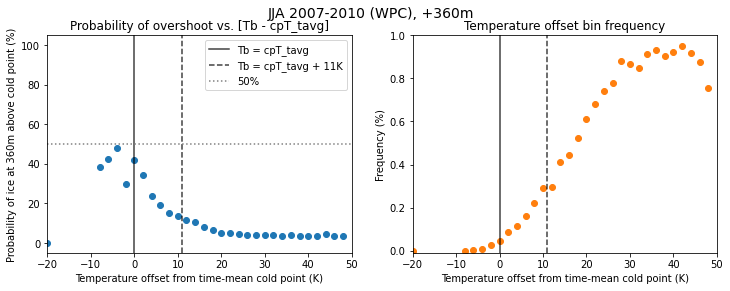

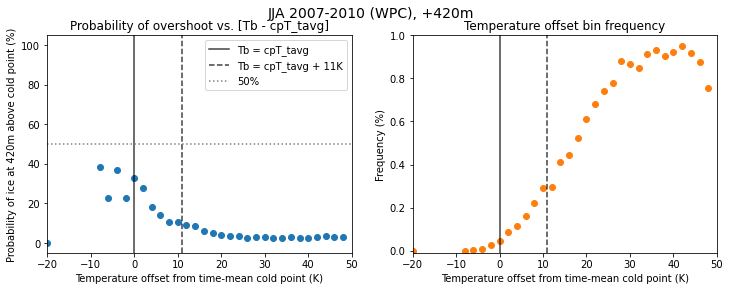

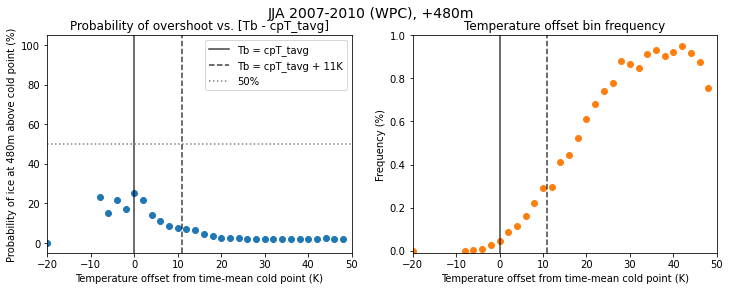

In [38]:
# diffs from AVERAGE cold point

for dz in dz_plot_list:
    tb = tb_dict[region]
    ice = dar_rel_dict[region].sel(cpz_offset=dz)
    offset = offset_dict[region]

    # bin the differences 
    diffs = tb_dict[region] - cpT_avg_dict[region].values
    diffs_binned = diffs.groupby_bins(diffs, bins=diff_bins)
    diff_counts = diffs_binned.count()

    # bin ice > min by the tb difference bins
    ice_nz = ice.where(ice > min_iwc)
    ice_nz_binned = ice_nz.assign_coords(time=diffs.time).groupby_bins(diffs, bins=diff_bins)
    ice_nz_counts = ice_nz_binned.count()

    # plot the fraction
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.axvline(0, color="k", alpha=0.75, label="Tb = cpT_tavg")
    ax1.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax1.axhline(50, color="gray", linestyle=":", label="50%")
    ax1.scatter(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    if plot_line:
        ax1.plot(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    ax1.set_ylim((-5, 105))
    ax1.set_xlim((diff_bins[0], diff_bins[-1]))
    ax1.legend(loc="upper right")
    ax1.set_title("Probability of overshoot vs. [Tb - cpT_tavg]")
    ax1.set_ylabel("Probability of ice at {z}m above cold point (%)".format(z=dz))
    ax1.set_xlabel("Temperature offset from time-mean cold point (K)")
    
    ax2.set_title("Temperature offset bin frequency")
    ax2.axvline(0, color="k", alpha=0.75, label="Tb = cpT")
    ax2.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax2.scatter(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    if plot_line:
        ax2.plot(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    ax2.set_ylabel("Frequency (%)")
    ax2.set_xlabel("Temperature offset from time-mean cold point (K)")
    ax2.set_xlim((diff_bins[0], diff_bins[-1]))
    ax2.set_ylim((-0.01, 1))

    plt.suptitle("{s} {y} ({r}), +{z}m".format(s=season, y=years_str, r=region, z=dz), fontsize=14)
    
    if save:
        if plot_line:
            extr = "_with_line"
        else:
            extr = ""
        plt.savefig(save_dir + "conditional_prob_overshoot_from_avg_cpT_{s}{y}_{r}{e}_{z}.png".format(s=season, y=years_str, r=region, e=extr, z=dz),
                    dpi=300, bbox_inches="tight")
    
    plt.show()


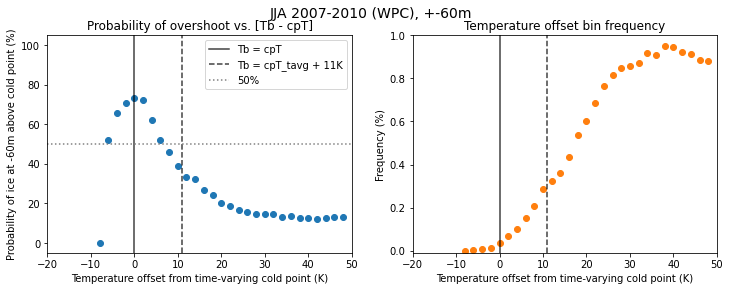

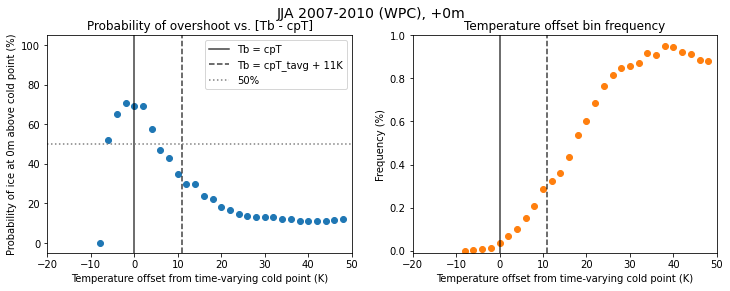

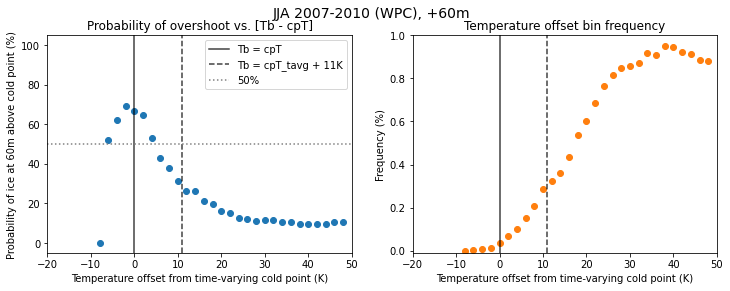

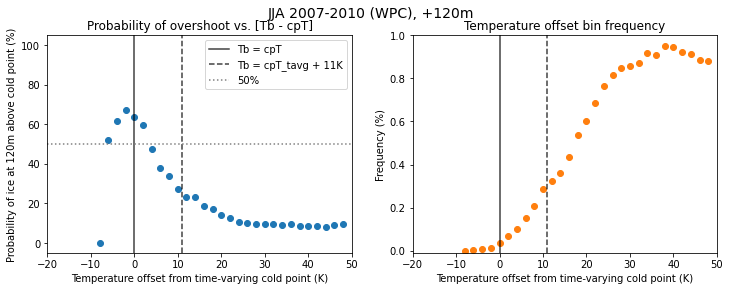

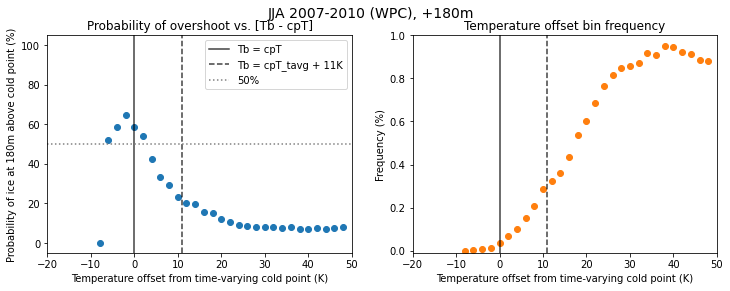

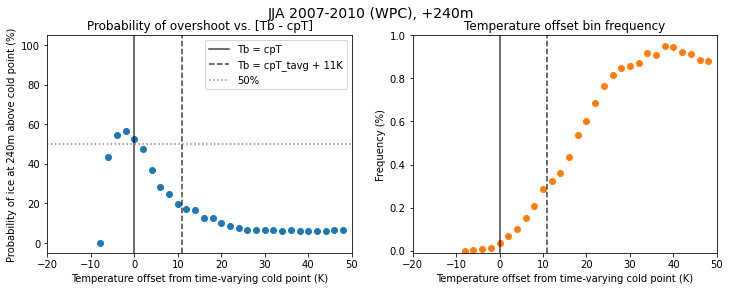

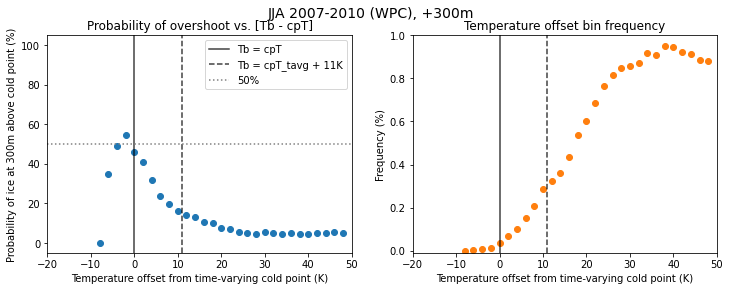

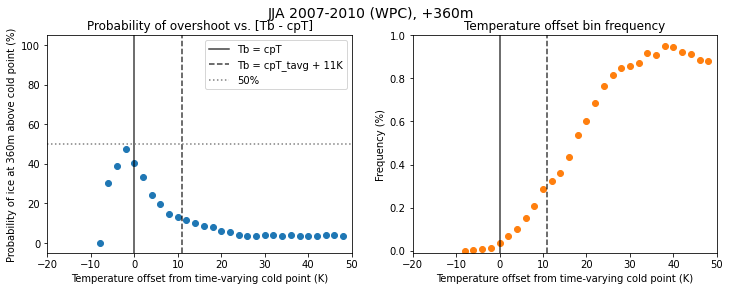

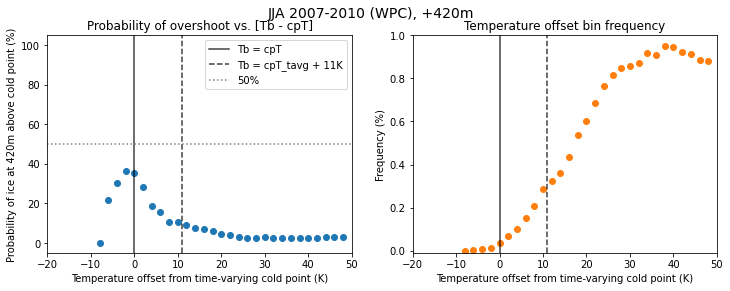

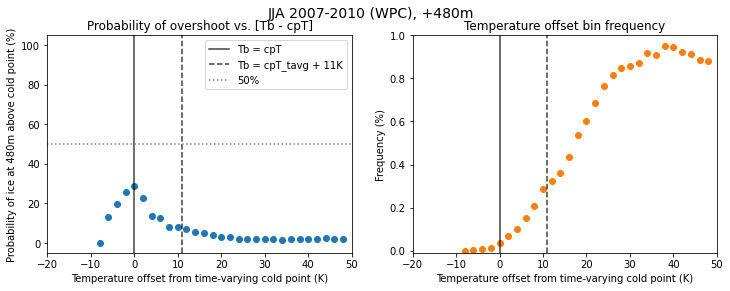

In [39]:
# diffs from LOCAL cold point

for dz in dz_plot_list:
    tb = tb_dict[region]
    ice = dar_rel_dict[region].sel(cpz_offset=dz)
    offset = offset_dict[region]

    # bin the differences 
    diffs = tb_dict[region] - cpT_dict[region].values
    diffs_binned = diffs.groupby_bins(diffs, bins=diff_bins)
    diff_counts = diffs_binned.count()

    # bin ice > min by the tb difference bins
    ice_nz = ice.where(ice > min_iwc)
    ice_nz_binned = ice_nz.assign_coords(time=diffs.time).groupby_bins(diffs, bins=diff_bins)
    ice_nz_counts = ice_nz_binned.count()

    # plot the fraction
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.axvline(0, color="k", alpha=0.75, label="Tb = cpT")
    ax1.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax1.axhline(50, color="gray", linestyle=":", label="50%")
    ax1.scatter(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    if plot_line:
        ax1.plot(diff_bins[:-1], (ice_nz_counts/diff_counts)*100., color="C0")
    ax1.set_ylim((-5, 105))
    ax1.set_xlim((diff_bins[0], diff_bins[-1]))
    ax1.legend(loc="upper right")
    ax1.set_title("Probability of overshoot vs. [Tb - cpT]")
    ax1.set_ylabel("Probability of ice at {z}m above cold point (%)".format(z=dz))
    ax1.set_xlabel("Temperature offset from time-varying cold point (K)")
    
    ax2.set_title("Temperature offset bin frequency")
    ax2.axvline(0, color="k", alpha=0.75, label="Tb = cpT")
    ax2.axvline(offset, color="k", linestyle="--", alpha=0.75, label="Tb = cpT_tavg + {}K".format(offset))
    ax2.scatter(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    if plot_line:
        ax2.plot(diff_bins[:-1], (diff_counts/tb.count())*100., color="C1")
    ax2.set_ylabel("Frequency (%)")
    ax2.set_xlabel("Temperature offset from time-varying cold point (K)")
    ax2.set_xlim((diff_bins[0], diff_bins[-1]))
    ax2.set_ylim((-0.01, 1))

    plt.suptitle("{s} {y} ({r}), +{z}m".format(s=season, y=years_str, r=region, z=dz), fontsize=14)
    
    if save:
        if plot_line:
            extr = "_with_line"
        else:
            extr = ""
        plt.savefig(save_dir + "conditional_prob_overshoot_from_local_cpT_{s}{y}_{r}{e}_{z}.png".format(s=season, y=years_str, r=region, e=extr, z=dz),
                    dpi=300, bbox_inches="tight")
    
    plt.show()
